In [1]:
import sys
import networkx as nx
import matplotlib.pyplot as plt
from generate_cubic_graphs import generate_cubic_graphs_with_geng

n = 10
try:
    def simple_progress(g, i):
        if i % 100 == 0:
            print(f"Got graph #{i}")

    graphs = generate_cubic_graphs_with_geng(n, connected=True, per_graph=simple_progress)
    number_of_graphs = len(graphs)
    print(f"Generated {number_of_graphs} graphs.")
    for i, G in enumerate(graphs, 1):
        plt.figure(i)
        nx.draw(G)
except Exception as e:
    print("Error:", e, file=sys.stderr)


Error: generate_cubic_graphs_with_geng() got an unexpected keyword argument 'per_graph'


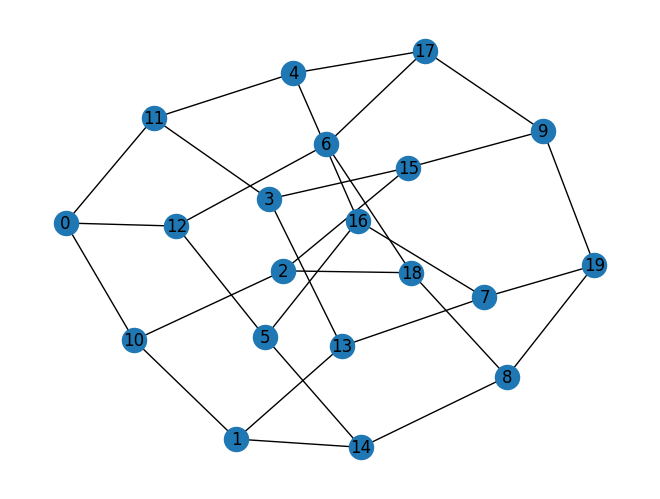

In [145]:
from find_cubic_local_mincut import *
import matplotlib.pyplot as plt

N, T = 20, 5

# Gs = all_cubic_graph_with_local_cuts(N=18, T=5)
# G = find_cubic_graph_with_local_cuts(N=20, T=5)
# Gs = generate_cubic_graphs_with_geng(10)
# for G in generate_cubic_graphs_with_geng(N):
if G := find_cubic_graph_with_local_cuts(N, T):
    nx.draw(G, with_labels=True)
    # print(f"Found {len(Gs)} suitable graph")
    # for i, G in enumerate(Gs[:10], 1):
    #     plt.figure(i, figsize=(4,4))
    #     nx.draw(G, with_labels=True)
        # subG = find_small_nonlocal_cut(G, 4)
        # if subG is not None:
        #     plt.figure(2 * i + 1, figsize=(2,2))
        #     nx.draw(subG, with_labels=True)

else:
    print("No graph found")

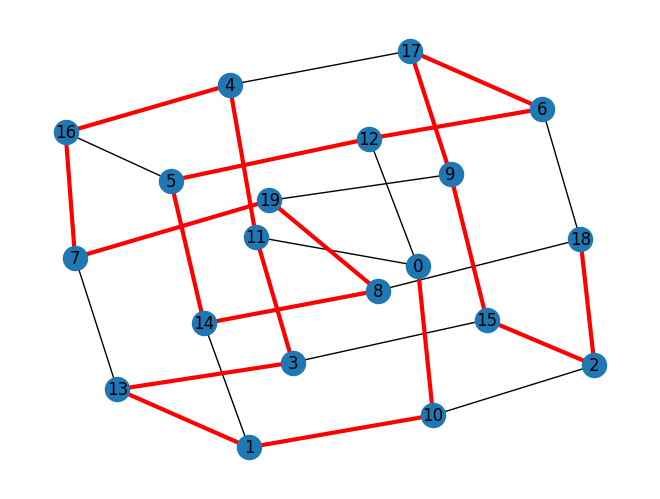

In [146]:
def find_all_hamiltonian_paths(graph):
    """
    Yields all Hamiltonian paths in a graph using backtracking.
    """
    n = len(graph.nodes)
    for start_node in graph.nodes:
        path = [start_node]
        visited = {start_node}

        def search(current_path):
            if len(current_path) == n:
                yield current_path
                return

            last_node = current_path[-1]
            for neighbor in graph.neighbors(last_node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    yield from search(current_path + [neighbor])
                    visited.remove(neighbor) # Backtrack

        yield from search(path)

p = next(find_all_hamiltonian_paths(G))
pos = nx.drawing.layout.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edges(
    G, pos=pos,
    edgelist=list(zip(p, p[1:])),
    edge_color='red', width=3.0
)

In [147]:
import networkx as nx

def visualize_markings(G, markings):
    """
    Visualizes the graph with marked edges emphasized.
    - Marked: Thick Green lines with a '✓' mark.
    - Unmarked: Thin Dashed Grey lines with a '✗' mark.
    """
    pos = nx.kamada_kawai_layout(G) # Kamada-Kawai usually looks best for regular graphs

    plt.figure(figsize=(5, 5))

    # 1. Separate edges into two lists
    marked_edges = [e for e, is_marked in markings.items() if is_marked]
    unmarked_edges = [e for e, is_marked in markings.items() if not is_marked]

    # nx.draw_networkx_nodes(G, pos, node_color='lightgrey', node_size=300, edgecolors='black')
    # nx.draw_networkx_edges(G, pos, edgelist=unmarked_edges, width=1.5)
    # nx.draw_networkx_edges(G, pos, edgelist=marked_edges, width=4.0)
    nx.draw(G, pos)

    # 5. Add the "Marks" (Text Labels on Edges)
    edge_labels = {}
    for edge, is_marked in markings.items():
        if is_marked:
            edge_labels[edge] = "✓" # Checkmark
        else:
            edge_labels[edge] = "✗" # Cross

    # Draw marks for marked edges (Green)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={e: "|" for e in marked_edges}, font_size=18, font_weight='bold',
                                 bbox=dict(alpha=0)) # bbox alpha=0 hides the text box background

    nx.draw_networkx_edges(
        G, pos=pos,
        edgelist=list(zip(p, p[1:])),
        edge_color='red', width=1.5
    )

    plt.show()


T=4
24


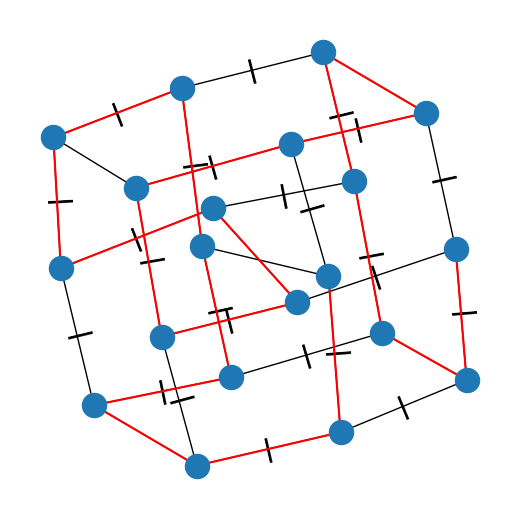

T=5
21


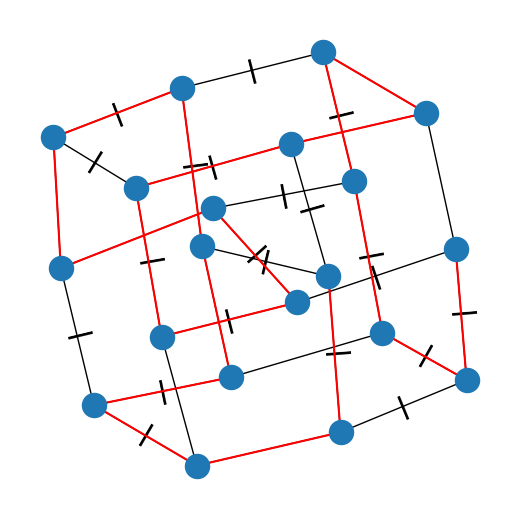

T=6
18


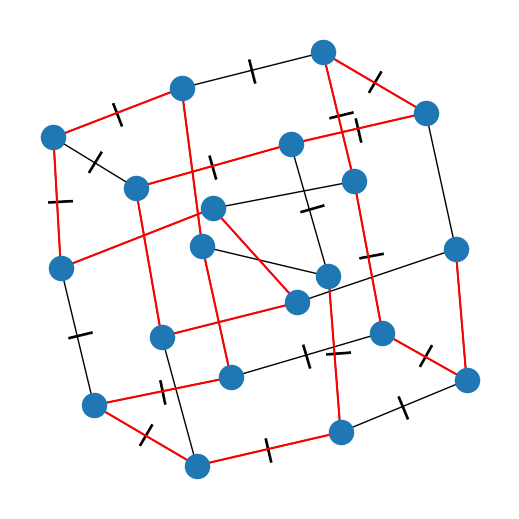

In [148]:
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
from pysat.formula import WCNF
from pysat.examples.rc2 import RC2

class GraphMarker:
    def __init__(self, G):
        self.G = G
        self.L = nx.line_graph(G)

        # Create a mapping from edge (node in L) to SAT variable ID (1, 2, 3...)
        self.edge_to_id = {edge: i+1 for i, edge in enumerate(self.L.nodes())}
        self.id_to_edge = {i: edge for edge, i in self.edge_to_id.items()}

    def _solve_wcnf(self, wcnf):
        with RC2(wcnf) as rc2:
            model = rc2.compute()
            if model is None:
                print("No solution found (UNSAT).")
                return None

            markings = {}
            model_set = set(model)
            for edge in self.G.edges():
                # Normalize edge lookup
                key = edge if edge in self.edge_to_id else (edge[1], edge[0])
                markings[edge] = (self.edge_to_id[key] in model_set)
            return markings

    def solve_problem_1(self):
        """
        Problem 1: Marked edges must have an Unmarked neighbor.
        Constraint: x_e -> (NOT x_n1 OR NOT x_n2 ...)
        CNF Clause: [-x_e, -x_n1, -x_n2, ...]
        """
        wcnf = WCNF()

        for e in self.L.nodes():
            e_id = self.edge_to_id[e]
            neighbor_ids = [self.edge_to_id[n] for n in self.L.neighbors(e)]

            # HARD Constraint: If e is Marked, at least one neighbor must be Unmarked.
            # Logic: NOT(e) OR NOT(n1) OR NOT(n2)...
            # In SAT terms: [-e_id, -n1_id, -n2_id...]
            wcnf.append([-e_id] + [-nid for nid in neighbor_ids])

            # SOFT Constraint: We WANT to mark edge 'e' (Maximize True)
            # Weight 1 for setting e to True
            wcnf.append([e_id], weight=1)

        return self._solve_wcnf(wcnf)

    def solve_problem_2(self):
        """
        Problem 2: EVERY edge (Marked or Unmarked) must have an Unmarked neighbor.
        Constraint: For any edge e, it implies (NOT x_n1 OR NOT x_n2 ...)
        CNF Clause: [-x_n1, -x_n2, ...] (The state of e itself doesn't relax the rule)
        """
        wcnf = WCNF()

        for e in self.L.nodes():
            neighbor_ids = [self.edge_to_id[n] for n in self.L.neighbors(e)]

            # HARD Constraint: Regardless of e's state, one neighbor must be Unmarked.
            # Logic: NOT(n1) OR NOT(n2) OR ...
            wcnf.append([-nid for nid in neighbor_ids])

            # SOFT Constraint: Maximize Marked edges
            e_id = self.edge_to_id[e]
            wcnf.append([e_id], weight=1)

        return self._solve_wcnf(wcnf)

    def solve_problem_3(self):
        """
        3. Clustered Unmarked Edges.
        - Rule A: Marked edges must have an Unmarked neighbor.
        - Rule B: Unmarked edges must have at least 2 Unmarked neighbors.
        """
        wcnf = WCNF()
        for e in self.L.nodes():
            e_id = self.edge_to_id[e]
            neighbor_ids = [self.edge_to_id[n] for n in self.L.neighbors(e)]

            # Rule A: Prevent "All Marked" around a marked edge
            # Clause: [-e, -n1, -n2, -n3, -n4]
            wcnf.append([-e_id] + [-nid for nid in neighbor_ids])

            # Rule B: Force Clusters.
            # Logic: If 'e' is Unmarked (False), it cannot have >=3 Marked neighbors.
            # CNF: For every trio of neighbors (a,b,c): NOT(a & b & c & !e)
            # Clause: [-a, -b, -c, e]
            for combo in combinations(neighbor_ids, 3):
                clause = [-c for c in combo] + [e_id]
                wcnf.append(clause)

            # Soft: Maximize Marked
            wcnf.append([e_id], weight=1)

        return self._solve_wcnf(wcnf)

# --- 3. Run and Compare ---

# Create a graph
marker = GraphMarker(G)

print("T=4")
res1 = marker.solve_problem_1()
print(sum(v for k, v in res1.items()))
visualize_markings(G, res1)

print("T=5")
res2 = marker.solve_problem_2()
print(sum(v for k, v in res2.items()))
visualize_markings(G, res2)

print("T=6")
res3 = marker.solve_problem_3()
print(sum(v for k, v in res3.items()))
visualize_markings(G, res3)